In [1]:
import os
import gc
from math import ceil
from typing import Tuple, Union

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import wandb
from tqdm import tqdm
from datasets import load_dataset

from upscaler import Upscaler
from colorizer import Colorizer
from dataloader import NoisyImageNetDataset

In [2]:
class Restorer(nn.Module):
    """Model that colorizes and upscales the images."""
    def __init__(
            self,
            kernel_size: Union[int, Tuple[int, int]] = 5,
            sigma_color: float = 0.1,
            sigma_space: Union[float, Tuple[float, float]] = 1.5,
        ) -> None:
        super().__init__()

        self.colorizer = Colorizer(kernel_size, sigma_color, sigma_space)
        self.upscaler = Upscaler()

    def forward(self, x):
        """Forward pass of the model.

        Args:
            x: The input tensor of shape (BATCH_SIZE, 1, 270, 512).

        Returns:
            The output tensor of shape (BATCH_SIZE, 3, 2160, 4096).
        """
        x = self.colorizer(x)  # (BATCH_SIZE, 3, 270, 512)
        x = self.upscaler(x)   # (BATCH_SIZE, 3, 2160, 4096)

        return x

In [3]:
LR                 = 1e-4
DEVICE             = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WANDB_LOG          = True
CACHE_DIR          = "/scratch/public_scratch/gp/DIP/ImageNet-1k/"
NUM_EPOCHS         = 1
BATCH_SIZE         = 8
WEIGHT_DECAY       = 1e-3
VAL_FREQUENCY      = 10000
MAX_VAL_BATCHES    = 1250
SCHEDULER_FACTOR   = 0.5
SCHEDULER_PATIENCE = 2
CHECKPOINT_DIR     = "/scratch/public_scratch/gp/DIP/checkpoints/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [6]:
val_dataset = load_dataset(
    'imagenet-1k', split='validation', streaming=True,
    cache_dir=CACHE_DIR, trust_remote_code=True
)
noisy_val_dataset = NoisyImageNetDataset(val_dataset)

In [8]:
sample = next(iter(noisy_val_dataset))

denoised_gray = sample['denoised_gray'].unsqueeze(0).to(DEVICE)
original_rgb  = sample['original_rgb'].unsqueeze(0).to(DEVICE)

In [18]:
model = Restorer().to(DEVICE)
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, "model_epoch_1_batch_20.pth"))['model_state_dict'])
model.eval()

with torch.no_grad():
    denoised_rgb = model(denoised_gray)

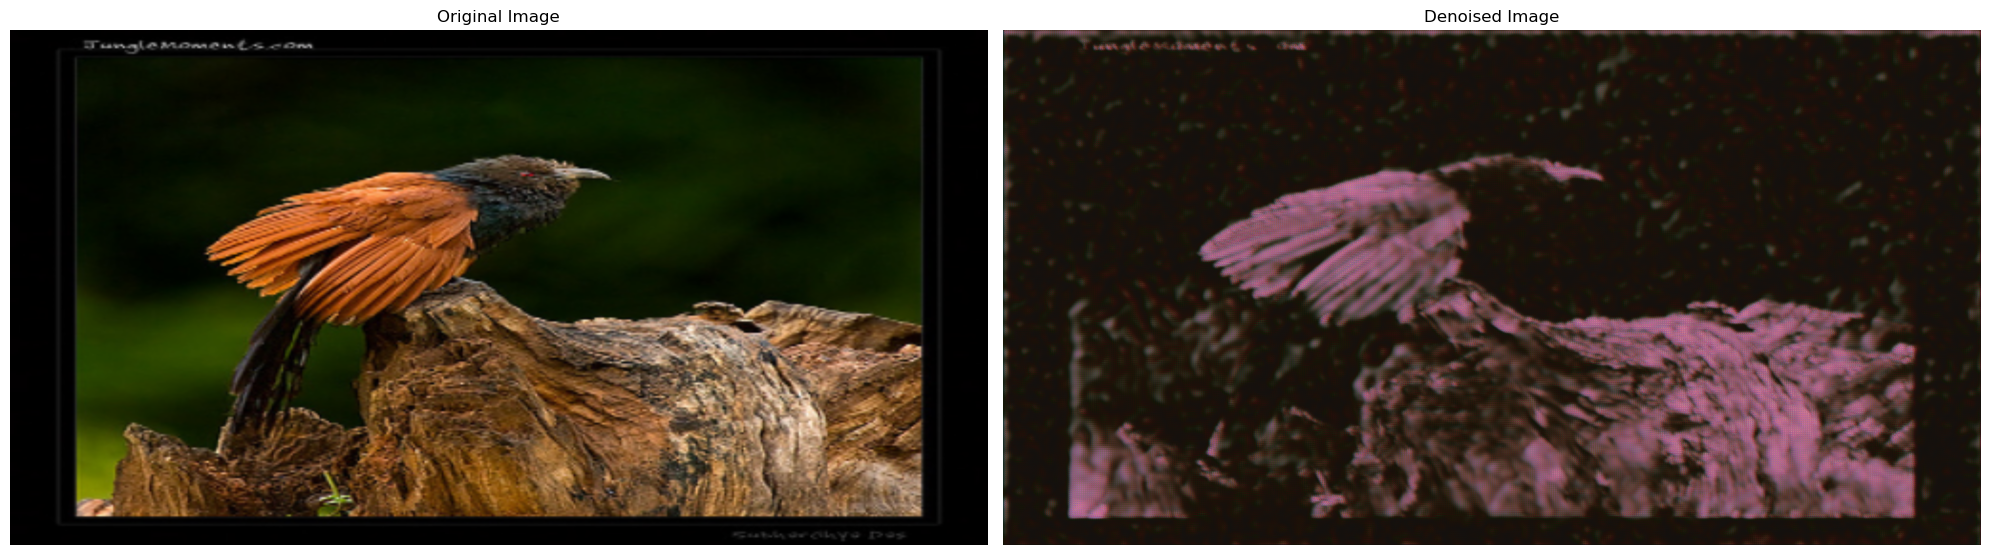

In [19]:
import matplotlib.pyplot as plt

upscaled_original = F.interpolate(original_rgb, scale_factor=8, mode='bilinear', align_corners=False)

_, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(upscaled_original[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(denoised_rgb[0].permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Denoised Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()